### DropConnect

DropConnect sets a randomly selected subset of weights within the network to zero. Each unit thus receives input from a random subset of units in the previous layer.


Since, the results seem to be very poor in the previous case even after doing hyper parameter tuning. Let's try a slightly different approach to help the model fit the data well.
Let's try to implement the [DropConnect](http://proceedings.mlr.press/v28/wan13.pdf) paper on the CIFAR10 dataset.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os

The paper suggests cropping the images into 24x24 to ensure more focus is put on the object in the image

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize CIFAR-10 images
    transforms.CenterCrop(24)  # Crop the image to 24x24
])

Now, let's load the train, test, valid datasets

In [3]:
train_dataset = datasets.CIFAR10(root='./.data', train=True, download=False, transform=transform)
test_dataset = datasets.CIFAR10(root='./.data', train=False, download=False, transform=transform)

In [4]:
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [5]:
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

### Define the DropConnect CNN Model

In [ ]:
class DropConnectCNN(nn.Module):
    def __init__(self, drop_prob=0.5):
        super(DropConnectCNN, self).__init__()
        
        # Define Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.loc_conv1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.loc_conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        # Calculate the correct input size for the fully connected layer
        # After 4 max pooling layers (each dividing dimensions by 2):
        # 24x24 -> 12x12 -> 6x6 -> 3x3 -> 1x1
        # So final conv output will be: 128 channels * 1 * 1
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.drop_prob = drop_prob
        self.dropconnect_mask = None

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # 12x12
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # 6x6
        x = F.relu(F.max_pool2d(self.loc_conv1(x), 2))  # 3x3
        x = F.relu(F.max_pool2d(self.loc_conv2(x), 2))  # 1x1
        
        x = x.view(x.size(0), -1)  # Flatten: [batch_size, 128]
        
        if self.dropconnect_mask is None:
            self.dropconnect_mask = torch.bernoulli(torch.full_like(self.fc1.weight.t(), 1 - self.drop_prob)).to(x.device)
        
        x = F.linear(x, self.fc1.weight * self.dropconnect_mask.t(), self.fc1.bias)
        x = F.relu(x)
        x = self.fc2(x)
        return x


### Setting up the Hyper-parameters

In [7]:
learning_rate = 0.001
epochs_stage1 = 100
epochs_stage2 = 50
epochs_stage3 = 25
drop_prob = 0.5
total_ensemble_models = 5

weight_decay_stage1 = 1e-4
weight_decay_stage2 = 5e-5
weight_decay_stage3 = 1e-5

In [8]:
def get_optimizer_for_stage(model, stage):
    if stage == 1:
        weight_decay = weight_decay_stage1
    elif stage == 2:
        weight_decay = weight_decay_stage2
    else:
        weight_decay = weight_decay_stage3
    
    return optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

### Ensemble Learning

The authors mention that they trained 12 different models with DropConnect. This implies model ensembling — they trained 12 separate networks and averaged their predictions for better accuracy. This approach improves the generalization of the model by combining multiple independently trained models.

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
models = [DropConnectCNN(drop_prob=drop_prob) for _ in range(total_ensemble_models)]
optimizers = [optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001) for model in models]
criterions = [nn.CrossEntropyLoss() for _ in range(total_ensemble_models)]

### Training the Ensemble Models

In [11]:
stage_losses = {1: [], 2: [], 3: []}
stage_accuracies = {1: [], 2: [], 3: []}

In [12]:
def train(model, optimizer, criterion, train_loader, epochs, stage):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track loss and accuracy for the epoch
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            epoch_correct += (predicted == labels).sum().item()
            epoch_total += labels.size(0)
        
        # Store loss and accuracy for this epoch and stage
        epoch_loss /= len(train_loader)
        epoch_accuracy = epoch_correct / epoch_total * 100
        stage_losses[stage].append(epoch_loss)
        stage_accuracies[stage].append(epoch_accuracy)
        
        print(f"Stage {stage}, Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

In [13]:
def validate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    model.train()  # Switch back to training mode

In [25]:
for stage, epochs in enumerate([epochs_stage1, epochs_stage2, epochs_stage3], 1):
    for model, optimizer, criterion in zip(models, optimizers, criterions):
        optimizer = get_optimizer_for_stage(model, stage)
        train(model, optimizer, criterion, train_loader, epochs, stage=stage)

Stage 1, Epoch 1/100, Loss: 1.7434, Accuracy: 35.03%
Stage 1, Epoch 2/100, Loss: 1.4051, Accuracy: 48.65%
Stage 1, Epoch 3/100, Loss: 1.2411, Accuracy: 55.34%
Stage 1, Epoch 4/100, Loss: 1.1024, Accuracy: 60.75%
Stage 1, Epoch 5/100, Loss: 0.9982, Accuracy: 64.91%
Stage 1, Epoch 6/100, Loss: 0.9215, Accuracy: 67.50%
Stage 1, Epoch 7/100, Loss: 0.8488, Accuracy: 70.25%
Stage 1, Epoch 8/100, Loss: 0.7937, Accuracy: 72.33%
Stage 1, Epoch 9/100, Loss: 0.7479, Accuracy: 73.84%
Stage 1, Epoch 10/100, Loss: 0.6907, Accuracy: 75.93%
Stage 1, Epoch 11/100, Loss: 0.6523, Accuracy: 77.16%
Stage 1, Epoch 12/100, Loss: 0.6200, Accuracy: 78.27%
Stage 1, Epoch 13/100, Loss: 0.5855, Accuracy: 79.47%
Stage 1, Epoch 14/100, Loss: 0.5500, Accuracy: 80.96%
Stage 1, Epoch 15/100, Loss: 0.5300, Accuracy: 81.36%
Stage 1, Epoch 16/100, Loss: 0.5045, Accuracy: 82.46%
Stage 1, Epoch 17/100, Loss: 0.4803, Accuracy: 83.37%
Stage 1, Epoch 18/100, Loss: 0.4420, Accuracy: 84.72%
Stage 1, Epoch 19/100, Loss: 0.4226, 

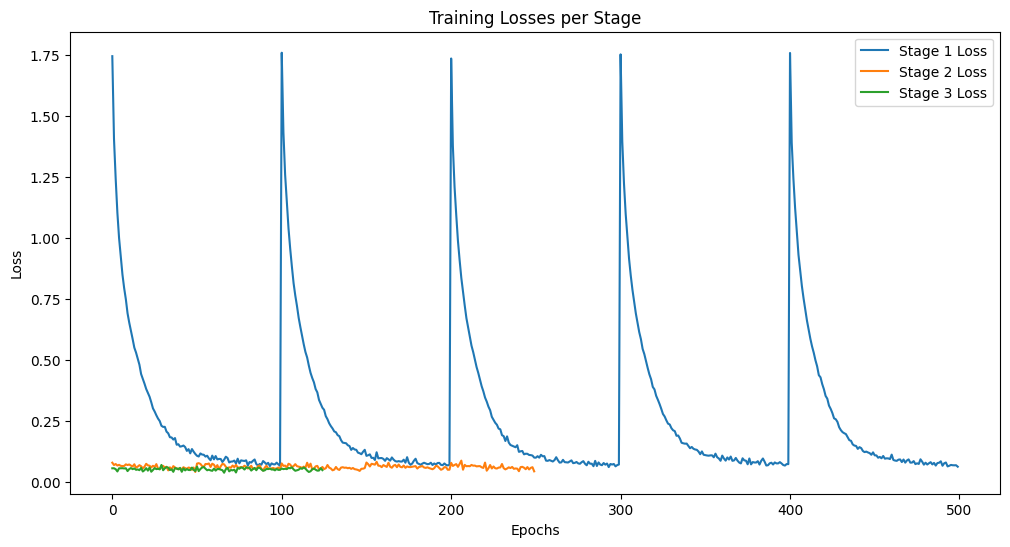

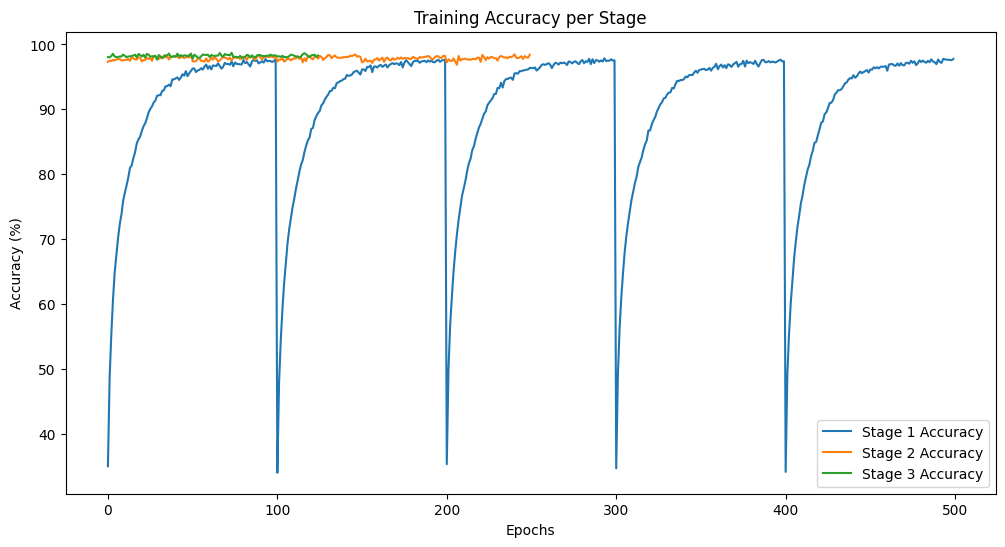

In [26]:
def plot_loss_accuracy():
    # Plot losses
    plt.figure(figsize=(12, 6))
    for stage in [1, 2, 3]:
        plt.plot(stage_losses[stage], label=f'Stage {stage} Loss')
    plt.title('Training Losses per Stage')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure(figsize=(12, 6))
    for stage in [1, 2, 3]:
        plt.plot(stage_accuracies[stage], label=f'Stage {stage} Accuracy')
    plt.title('Training Accuracy per Stage')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# Call the plotting function
plot_loss_accuracy()

### Testing the Model on Holdout dataset

In [28]:
def ensemble_predict(models, loader):
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get predictions from all models
            outputs = [model(inputs) for model in models]
            # Average the outputs
            avg_output = torch.mean(torch.stack(outputs), dim=0)
            _, predicted = torch.max(avg_output, 1)
            
            # Calculate accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct, total

def evaluate(models, loader, dataset_type):
    # Set all models to eval mode
    for model in models:
        model.eval()
        model.to(device)
    
    correct, total = ensemble_predict(models, loader)
    accuracy = 100 * correct / total
    print(f"{dataset_type} Accuracy: {accuracy:.2f}%")
    
    # Set models back to train mode
    for model in models:
        model.train()
        
    return accuracy

In [29]:
# Evaluate on validation set
val_accuracy = evaluate(models, val_loader, 'Validation')

Validation Accuracy: 81.53%


In [30]:
test_accuracy = evaluate(models, test_loader, 'Test')

Test Accuracy: 81.36%


### Save model

In [36]:
import os

save_dir = './trained_ensemble_models/'
os.makedirs(save_dir, exist_ok=True)

# Save each model in the ensemble
for idx, model in enumerate(models):
    try:
        model_path = os.path.join(save_dir, f'dropconnect_cifar_model_{idx + 1}.pth')
        torch.save(model.state_dict(), model_path)
        print(f'Successfully saved model {idx} to {model_path}')
    except Exception as e:
        print(f'Error saving model {idx}: {str(e)}')

print(f'Saved {len(models)} ensemble models to {save_dir}')

Successfully saved model 0 to ./trained_ensemble_models/dropconnect_cifar_model_1.pth
Successfully saved model 1 to ./trained_ensemble_models/dropconnect_cifar_model_2.pth
Successfully saved model 2 to ./trained_ensemble_models/dropconnect_cifar_model_3.pth
Successfully saved model 3 to ./trained_ensemble_models/dropconnect_cifar_model_4.pth
Successfully saved model 4 to ./trained_ensemble_models/dropconnect_cifar_model_5.pth
Saved 5 ensemble models to ./trained_ensemble_models/


In [16]:
save_dir = './trained_ensemble_models/'
models = []

# Define the number of models you have saved (in your case, probably the same as len(models))
num_models = 5  # Adjust this according to the number of models in your ensemble

# Load each model
for idx in range(num_models):
    try:
        model = DropConnectCNN()
        model_path = os.path.join(save_dir, f'dropconnect_cifar_model_{idx + 1}.pth')
        
        # Load the saved state dict into the model
        model.load_state_dict(torch.load(model_path))
        model.eval() 
        
        # Append the model to the models list
        models.append(model)
        
        print(f'Successfully loaded model {idx + 1} from {model_path}')
    except Exception as e:
        print(f'Error loading model {idx + 1}: {str(e)}')

print(f'Loaded {len(models)} models into the ensemble.')

/tmp/ipykernel_2204020/3524132021.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Successfully loaded model 1 from ./trained_ensemble_models/dropconnect_cifar_model_1.pth
Successfully loaded model 2 from ./trained_ensemble_models/dropconnect_cifar_model_2.pth
Successfully loaded model 3 from ./trained_ensemble_models/dropconnect_cifar_model_3.pth
Successfully loaded model 4 from ./trained_ensemble_models/dropconnect_cifar_model_4.pth
Successfully loaded model 5 from ./trained_ensemble_models/dropconnect_cifar_model_5.pth
Loaded 5 models into the ensemble.


### Let's visualize our dataset and model using t-SNE

In [20]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np

In [26]:
def collect_ensemble_predictions(models, loader, device):
    all_features = []
    true_labels = []
    ensemble_predictions = []
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            batch_predictions = []
            
            # Get predictions from each model
            for model in models:
                output = model(data)
                batch_predictions.append(F.softmax(output, dim=1))
            
            # Average predictions across models
            avg_predictions = torch.mean(torch.stack(batch_predictions), dim=0)
            _, predicted = torch.max(avg_predictions, 1)
            
            # Store results
            all_features.append(avg_predictions.cpu().numpy())
            true_labels.append(target.cpu().numpy())
            ensemble_predictions.append(predicted.cpu().numpy())
    
    # Concatenate results
    all_features = np.concatenate(all_features, axis=0)
    true_labels = np.concatenate(true_labels)
    ensemble_predictions = np.concatenate(ensemble_predictions)
    
    return all_features, true_labels, ensemble_predictions

In [27]:
# Collect predictions
features, true_labels, predictions = collect_ensemble_predictions(models, test_loader, device)

Text(0.5, 1.0, 't-SNE: True Labels')

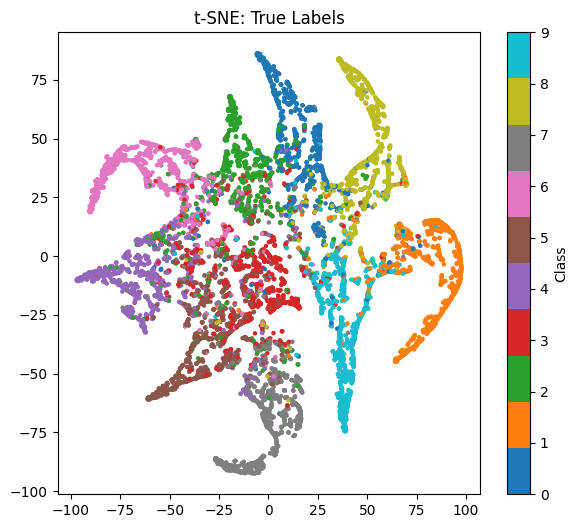

In [31]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

# Visualize results
plt.figure(figsize=(15, 6))

# Plot 1: True Labels
plt.subplot(121)
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=true_labels, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10), label="Class")
plt.title("t-SNE: True Labels")


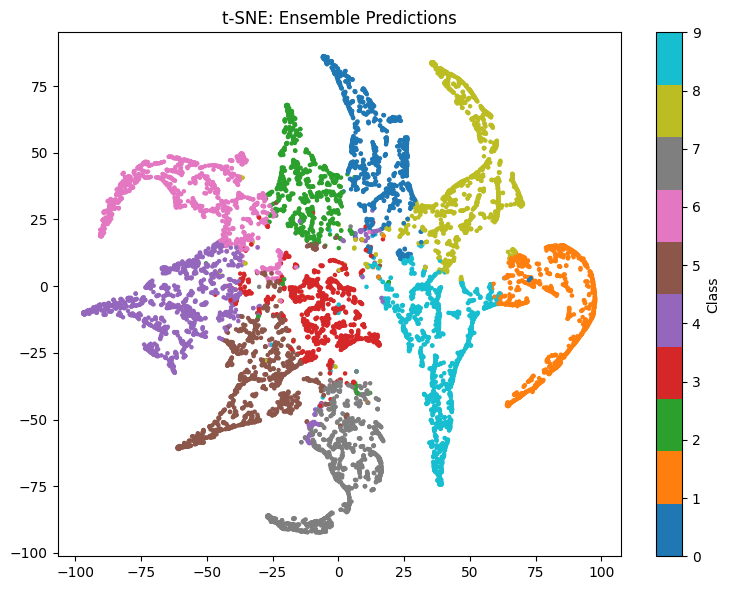

In [32]:
# Plot 2: Predicted Labels
plt.figure(figsize=(15, 6))
plt.subplot(122)
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=predictions, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10), label="Class")
plt.title("t-SNE: Ensemble Predictions")

plt.tight_layout()
plt.show()